# Grover-Search Variant of the Decoder

This is based on work in Landsman, Kevin A., et al. "Verified quantum information scrambling." _Nature_ 567.7746 (2019): 61-65. Here we construct the Grover-search variant of the decoder for the teleportation protocol based on Figure 4 of the paper.

In [39]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, BasicAer, IBMQ
import json
import os
import matplotlib.pyplot as plt

In [15]:
backend = BasicAer.get_backend('qasm_simulator')

In [16]:
def initialize(qc, statenum):
    """
    Prepare an eigenstate of the Pauli X, Y, or Z operator.
    """
    # statenum == 0, do nothing (|0>)
    
    if statenum == 1: #|1>
        qc.x(0)
    elif statenum == 2: #|+>
        qc.h(0)
    elif statenum == 3: #|->
        qc.x(0)
        qc.h(0)
    elif statenum == 4: # y eigenstate
        qc.y(0)
        qc.h(0)
        qc.s(0)
    elif statenum == 5: # y eigenstate
        qc.x(0)
        qc.y(0)
        qc.h(0)
        qc.s(0)
        
def epr(qc, a, b):
    """
    Create an EPR pair between qubits at a and b.
    """
    qc.h(a)
    qc.cx(a, b)

def eprs(qc):
    """
    Create the EPR pairs necessary for the teleporation protocol, i.e.
    on the last two qubits and on pairs of qubits above (excluding the first qubit).
    """
    n = len(qc.qubits)
    epr(qc, n-2, n-1)
    for i in range((n-3)//2):
        epr(qc, i+1, n-3-i)

    
def random(qc, qubits, a, params=[], layers=1, conj=False, orig=True):
    """
    Model the black hole as a "random" unitary parameterized by `a` (scrambling parameter).
    Setting orig=True replicates Figure 8 of the paper, while orig=False uses CZ and RX
    gates instead of XX and RZ gates, since this is more natural for the IBM gate basis.
    """
    layers *= 2
    n = len(qubits)
    if len(params) == 0:
        params = np.ones(n*layers) * np.pi/2
    
    pind = 0
    for i in range(layers):
        # two-qubit gates
        twos = n
        if n == 2:
            twos = n - 1
        for j in range(twos):
            t = np.pi/2
            if conj:
                t *= -1
            j2 = (j + 1) % n
            if orig:
                qc.rxx(t, qubits[j], qubits[j2])
            else:
                qc.cz(qubits[j], qubits[j2])
        # single-qubit rotations
        for j in range(n):
            t = params[pind]
            if conj:
                t *= -1
            if i % 2 == 1:
                t *= -1
            if orig:
                qc.rz(a*t, qubits[j])
            else:
                qc.rx(a*t, qubits[j])
            pind += 1
    return params


def end(qc, statenum):
    """
    Undo the state preparation of |psi>, so we can measure how similar the teleported
    state is to the initial state.
    """
    # statenum == 0, do nothing (|0>)
    i = len(qc.qubits) - 1
    if statenum == 1: #|1>
        qc.x(i)
    elif statenum == 2: #|+>
        qc.h(i)
    elif statenum == 3: #|->
        qc.h(i)
        qc.x(i)
    elif statenum == 4: # y eigenstate
        qc.sdg(i)
        qc.h(i)
        qc.y(i)
    elif statenum == 5: # y eigenstate
        qc.sdg(i)
        qc.h(i)
        qc.y(i)
        qc.x(i)
        
def bell_measure_prep(qc, crx, crz):
    """
    Add the gates needed for a Bell measurement.
    """
    n = len(qc.qubits)
    q1 = n//2 - 1
    q2 = n//2
    qc.cx(q1, q2)
    qc.h(q1)
    
def measure(qc, crx, crz, cr, only_cr=False):
    """
    Measure the Hawking-radiated qubit, Bob's complement, and the teleported qubit.
    """
    n = len(qc.qubits)
    q1 = n//2 - 1
    q2 = n//2
    
    qc.barrier()
    
    if not only_cr:
        qc.measure(q1, crz)
        qc.measure(q2, crx)
    
    qc.measure(n - 1, cr)

In [17]:
def grover(qc, q1, q2):
    """
    Grover search operator.
    """
    qc.barrier()
    qc.rz(np.pi, q1)
    qc.rx(np.pi, q1)
    qc.rx(np.pi, q2)
    qc.swap(q1, q2)
    qc.rz(np.pi, q1)
    
    
def random_transpose(qc, qubits, a, params=[], layers=1, conj=False, orig=True):
    """
    Transpose of the unitary implemented in `random()`. 
    Since U^dagger = U^(-1) => U^T = (U^(-1))*. Setting conj=False gives U^T.
    """
    layers *= 2
    n = len(qubits)
    if len(params) == 0:
        params = np.ones(n*layers) * np.pi/2
    
    params_reversed = params[::-1]
    pind = 0
    for i in range(layers):
        # single-qubit rotations
        for j in range(n-1, -1, -1):
            t = params_reversed[pind]
            if conj:
                t *= -1
            if (i+1) % 2 == 1:
                t *= -1
            if orig:
                qc.rz(a*t, qubits[j])
            else:
                qc.rx(a*t, qubits[j])
            pind += 1
            
        # two-qubit gates
        twos = n - 1 
        if n == 2:
            twos = n - 2
        for j in range(twos, -1, -1):
            t = np.pi/2
            if conj:
                t *= -1
            j2 = (j + 1) % n
            if orig:
                qc.rxx(t, qubits[j], qubits[j2])
            else:
                qc.cz(qubits[j], qubits[j2])
        
    return params

def random2(qc, qubits, layers=1):
    """
    Scrambling unitary in Figure 9.
    """
    n = len(qubits)
    
    for i in range(layers):
        # 1st layer of Z gates.
        twos = n

        if n == 2:
            twos = n - 1
        
        for j in range(twos-1, -1, -1):
            j2 = (j + 1) % n
            qc.cz(min(qubits[j], qubits[j2]), max(qubits[j], qubits[j2]))
            
        # Layer of H gates.
        for j in range(n):
            qc.h(j)
        
        # 2nd layer of Z gates.
        for j in range(twos):
            j2 = (j - 1) % n
            qc.cz(min(qubits[j], qubits[j2]), max(qubits[j], qubits[j2]))
            
def random2_transpose(qc, qubits, layers=1):
    pass

Check if we got the tranpose circuit right. The transposed circuit should be in the reverse order of the original circuit.

In [102]:
n = 4
orig=True

qc1 = QuantumCircuit(n)
qc2 = QuantumCircuit(n)

random(qc1, np.arange(n), 1, orig=orig)
random_transpose(qc2, np.arange(n), 1, orig=orig)

print(qc1)
print()
print(qc2)

     ┌────────────┐                            ┌────────────┐┌──────────┐»
q_0: ┤0           ├────────────────────────────┤1           ├┤ RZ(pi/2) ├»
     │  RXX(pi/2) │┌────────────┐ ┌──────────┐ │            │└──────────┘»
q_1: ┤1           ├┤0           ├─┤ RZ(pi/2) ├─┤            ├────────────»
     └────────────┘│  RXX(pi/2) │┌┴──────────┴┐│  RXX(pi/2) │┌──────────┐»
q_2: ──────────────┤1           ├┤0           ├┤            ├┤ RZ(pi/2) ├»
                   └────────────┘│  RXX(pi/2) ││            │├──────────┤»
q_3: ────────────────────────────┤1           ├┤0           ├┤ RZ(pi/2) ├»
                                 └────────────┘└────────────┘└──────────┘»
«     ┌────────────┐                            ┌────────────┐┌───────────┐
«q_0: ┤0           ├────────────────────────────┤1           ├┤ RZ(-pi/2) ├
«     │  RXX(pi/2) │┌────────────┐┌───────────┐ │            │└───────────┘
«q_1: ┤1           ├┤0           ├┤ RZ(-pi/2) ├─┤            ├─────────────
«     └────────────┘│

Now let's check by multiplying the complex conjugate of the the transposed circuit with the original, which should give us the identity. This means that all measurements should be 0.

In [114]:
n = 4
params = np.random.rand(2*n) * 2 * np.pi
#params = []
orig=False

qc3 = QuantumCircuit(n)

random(qc3, np.arange(n), 1, params=params, orig=orig)
random_transpose(qc3, np.arange(n), 1, conj=True, params=params, orig=orig)
qc3.measure_all()

print(qc3)

# qc3 should be the Identity, so we get 0000.
job = execute(qc3, backend, shots=1000)
counts = job.result().get_counts()
print(counts)

                               ┌────────────┐                         »
   q_0: ─■───────────────────■─┤ RX(2.9939) ├─■─────────────────────■─»
         │    ┌────────────┐ │ └────────────┘ │    ┌──────────────┐ │ »
   q_1: ─■──■─┤ RX(5.7834) ├─┼────────────────■──■─┤ RX(-0.71991) ├─┼─»
            │ └────────────┘ │ ┌────────────┐    │ └──────────────┘ │ »
   q_2: ────■───────■────────┼─┤ RX(2.8626) ├────■────────■─────────┼─»
                    │        │ ├────────────┤             │         │ »
   q_3: ────────────■────────■─┤ RX(6.2492) ├─────────────■─────────■─»
                               └────────────┘                         »
meas_0: ══════════════════════════════════════════════════════════════»
                                                                      »
meas_1: ══════════════════════════════════════════════════════════════»
                                                                      »
meas_2: ════════════════════════════════════════════════════════

The transpose circuit is working!

Let's add the Grover subcircuit as in Fig. 4 of the paper. Note that we don't implement the post-selection variant of the Grover-search decoder.

In [115]:
def experiment_with_grover(n, s, alpha, layers=1, params=None, shots=1000, display=False, orig=True):
    """
    Simulate a circuit for a given set of parameters and return both it and the teleportation fidelity.
    Returns circuit, F, P, N
    """
    only_cr = True
    
    qr = QuantumRegister(n)
    crx = ClassicalRegister(1, name='crb1')
    crz = ClassicalRegister(1, name='crb2')
    cr = ClassicalRegister(1, name='cr')
    circ = QuantumCircuit(qr, crx, crz, cr)
    initialize(circ, s)
    eprs(circ)
    
    if params is None:
        params = random(circ, np.arange(0, n//2), alpha, layers=layers, orig=orig)
    
    else:
        random(circ, np.arange(0, n//2), alpha, layers=layers, params=params, orig=orig)
    random(circ, np.arange(n//2, 2*(n//2)), alpha, layers=layers, params=params, conj=True, orig=orig)

    grover(circ, n//2-1, n//2)
    random_transpose(circ, np.arange(n//2, 2*(n//2)), alpha, layers=layers, params=params, orig=orig)
    grover(circ, n-2, n-1)
    end(circ, s)
    measure(circ, crx, crz, cr, only_cr=only_cr)
    
    if display:
        print(circ)
    
    job = execute(circ, backend, shots=shots)
    counts = job.result().get_counts()
    
    #print(counts)
    
    F = counts['0 0 0']/sum(counts.values())
    P = 0
    N = 0
    
    return circ, F, P, N

In [116]:
def simulate(n, orig, grover=False):
    """
    Run through different values of the scrambling parameter and assemble the simulation results.
    """
    layers = 1
    alphas = np.linspace(0, 1, 10)
    y = []
    params = np.ones(n*layers) * np.pi/2
    circuits = []
    for a in alphas:
        avg = np.zeros(3)
        for s in range(6):
            if grover:
                c, F, P, N = experiment_with_grover(n, s, a, layers=layers, params=params, orig=orig) 
            
            else:
                c, F, P, N = experiment(n, s, a, layers=layers, params=params, orig=orig)
            
            avg += np.array([F, P, N])
            circuits.append(c)

        avg /= 6
        y.append(avg)
    return y, alphas, circuits

Let's run the simulations.

In [117]:
all_circuits = []
all_y = []
alphas = None
for n in range(5, 17, 2):
    for i in range(0, 2):
        y, alphas, circuits = simulate(n, orig=bool(i), grover=True)
        all_circuits.append(circuits)
        all_y.append(y)
all_y = np.array(all_y)

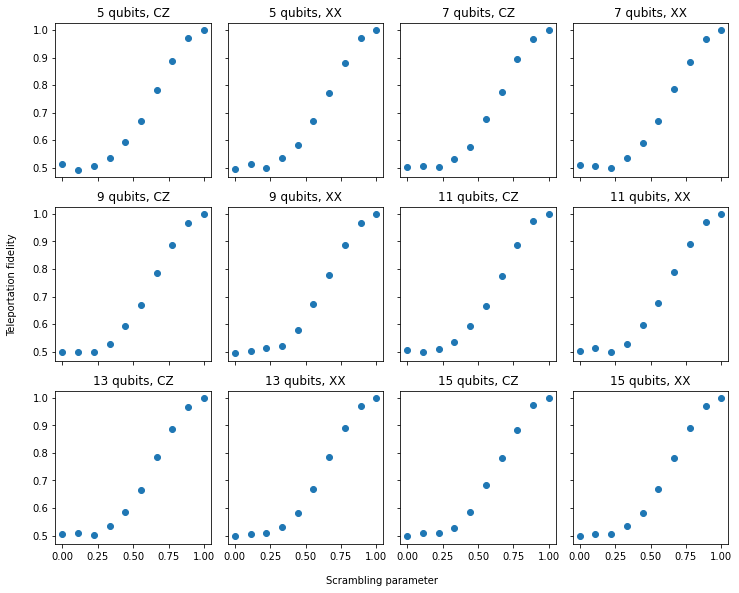

In [119]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_sim(k):
    fig, axs = plt.subplots(3, 4, sharex=True, sharey=True, figsize=(10, 8))
    cind = 0
    names = ['Teleportation fidelity', 'Prob. of successful measurement', 'Effective noise factor']
    
    for n in range(5, 17, 2):
        for i in range(0, 2):
            x1 = cind // 4
            x2 = cind % 4
            y = all_y[cind]
            axs[x1, x2].scatter(alphas, y[:, k])
            label = 'XX'
            
            if i == 0:
                label = 'CZ'
            axs[x1, x2].set_title(str(n) + ' qubits, ' + label)
            cind += 1

    fig.text(0.5, -0.02, 'Scrambling parameter', ha='center')
    fig.text(-0.02, 0.5, names[k], va='center', rotation='vertical')
    plt.tight_layout()
    plt.show()

plot_sim(0)

Great! The teleportation fidelities are what we expect. Note that we can only compute the fidelities when using the Grover-search decoder.

Now let's run on the actual hardware.

In [25]:
IBMQ.load_account()
provider = IBMQ.get_provider(group='open')

We saved data from the jobs, so you only need to process them to plot the data. We add the function that executes the jobs on the IBM devices for reference.

In [27]:
def run(n, i_choices=[0, 1], j_choices=[0, 1]):
    """
    Run an n-qubit circuit on IBM device(s) for different circuits (CZ or XX)
    and with different compiler optimization levels at the max # of shots.
    """
    if not os.path.exists('data'):
        os.makedirs('data')
    
    all_outs = []
    for i in i_choices: # CZ, XX
        for j in j_choices: # optimization level
            if n <= 5:
                backends = ['ibmq_16_melbourne', 'ibmq_burlington', 'ibmq_essex', 'ibmq_london', 'ibmq_ourense', 'ibmq_rome', 'ibmq_vigo', 'ibmq_5_yorktown']
            
            else:
                backends = ['ibmq_16_melbourne']
            outs = []
            for b in backends:
                qbackend = provider.get_backend(b)
                out = execute(all_circuits[(n-5) + i], qbackend, shots=8192, optimization_level=round(3*j))
                job_monitor(out)   
        
                outs.append(out)
            all_outs.append(outs)
    return all_outs

In [43]:
def process_files(n, i_choices=[0, 1], j_choices=[0, 1]):
    """
    Process the results of the IBM Q jobs stored in JSON files. Calculates the teleportation fidelity.
    """
    oind = 0
    all_ys = []

    for i in i_choices: # CZ, XX
        for j in j_choices: # optimization level
            
            if n <= 5:
                backends = ['ibmq_16_melbourne', 'ibmq_burlington', 'ibmq_essex', 'ibmq_london', 'ibmq_ourense', 'ibmq_rome', 'ibmq_vigo', 'ibmq_5_yorktown']
            
            else:
                backends = ['ibmq_16_melbourne']
                
            backend_ys = []
            
            for k in range(len(backends)):
                b = backends[k] 
                
                with open('data/' + b + '_orig_' + str(i) + '_opt_' + str(3*j) + '.json', 'r') as dataFile:
                    data = json.load(dataFile)
                                      
                l = 0
                oy = []
                
                for a in alphas:
                    avg = np.zeros(3)
                    for s in range(6):
                        counts = data['results'][l]['data']['counts']
                        F = counts['0x0']/sum(counts.values())
                        P = 0
                        N = 0
                        avg += np.array([F, P, N])
                        l += 1
                    avg /= 6
                    oy.append(avg)

                backend_ys.append(oy)
                
            all_ys.append(backend_ys)
            oind += 1
    
    return np.array(all_ys)

In [44]:
def plot_5(orig, opt, all_ys, m):
    i = int(orig)
    cind = i
    j = opt
    ys = all_ys[2*i + j]
    backends = ['ibmq_16_melbourne', 'ibmq_burlington', 'ibmq_essex', 'ibmq_london', 'ibmq_ourense', 'ibmq_rome', 'ibmq_vigo', 'ibmq_5_yorktown']    
    names = ['Teleportation fidelity', 'Prob. of successful measurement', 'Effective noise factor']
    metrics = ['F', 'P', 'N']
    fig, axs = plt.subplots(2, 4, sharex=True, sharey=True, figsize=(10, 6))
    
    for i in range(len(backends)):
        x1 = i // 4
        x2 = i % 4
        axs[x1, x2].scatter(alphas, ys[i][:, m], label='Hardware')
        axs[x1, x2].scatter(alphas, all_y[cind][:, m], label='Simulation')
        axs[x1, x2].set_title(backends[i])
#         axs[x1, x2].set_ylim(0.5, 1)

        if i == 0:
            axs[x1, x2].legend(loc='upper left')
            
    txt1 = fig.text(0.5, -0.02, 'Scrambling parameter', ha='center')
    txt2 = fig.text(-0.02, 0.5, names[m], va='center', rotation='vertical')
    label = 'CZ'
    
    if orig:
        label = 'XX'
    
    level = 'full'
    
    if opt == 0:
        level = 'no'
    
    main = '5 qubits, ' + label + ' circuit, ' + level + ' compiler optimization'
    txt3 = fig.text(0.5, 1.0, main, ha='center', fontsize=16)
    plt.tight_layout()
    plt.savefig('out/5q_' + label + '_' + level + '_' + metrics[m] + '.pdf', bbox_extra_artists=(txt1, txt2, txt3), bbox_inches='tight')

In [ ]:
def plot_n(orig, opt, ns, all_ys, m=0):
    o = int(orig)
    fig, axs = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(8, 8))
    names = ['Teleportation fidelity', 'Prob. of successful measurement', 'Effective noise factor']
    metrics = ['F', 'P', 'N']
    for i in range(len(ns)):
        x1 = i // 2
        x2 = i % 2
        cind = 2*(i+1) + o
        axs[x1, x2].scatter(alphas, all_ys[i][0][0][:, m], label='Hardware')
        axs[x1, x2].scatter(alphas, all_y[cind][:, m], label='Simulation')
        axs[x1, x2].set_title(str(ns[i]) + ' qubits')
        if i == 0:
            axs[x1, x2].legend(loc='upper left')
    txt1 = fig.text(0.5, -0.02, 'Scrambling parameter', ha='center')
    txt2 = fig.text(-0.02, 0.5, names[m], va='center', rotation='vertical')
    label = 'CZ'
    level = 'full'
    
    if orig:
        label = 'XX'
    
    if opt == 0:
        level = 'no'
        
    main = label + ' circuit, ' + level + ' compiler optimization'
    txt3 = fig.text(0.5, 1.0, main, ha='center', fontsize=16)
    plt.tight_layout()
    plt.savefig('out/16q_grover_' + label + '_' + metrics[m] + '.pdf', bbox_extra_artists=(txt1, txt2, txt3), bbox_inches='tight')

## 5-Qubit Protocol

In [45]:
n = 5
ys_5 = process_files(n)

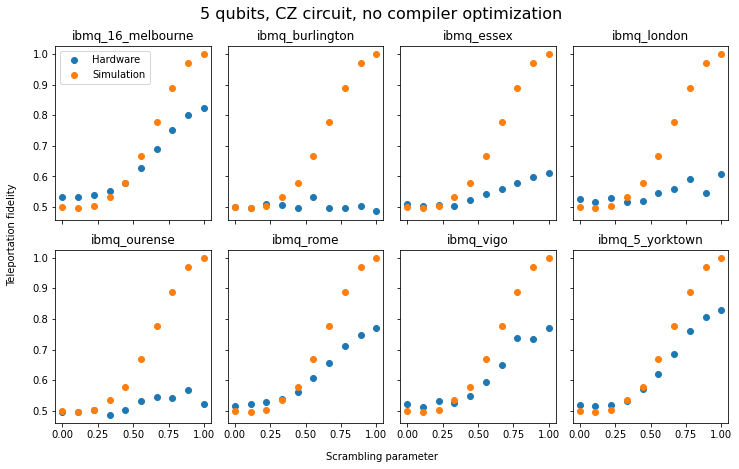

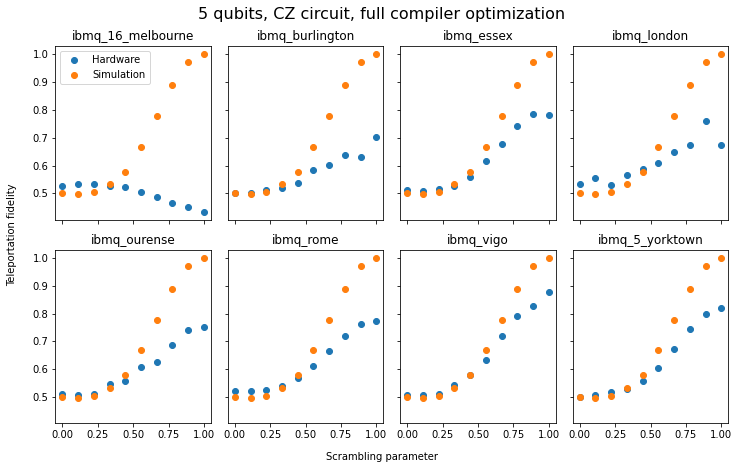

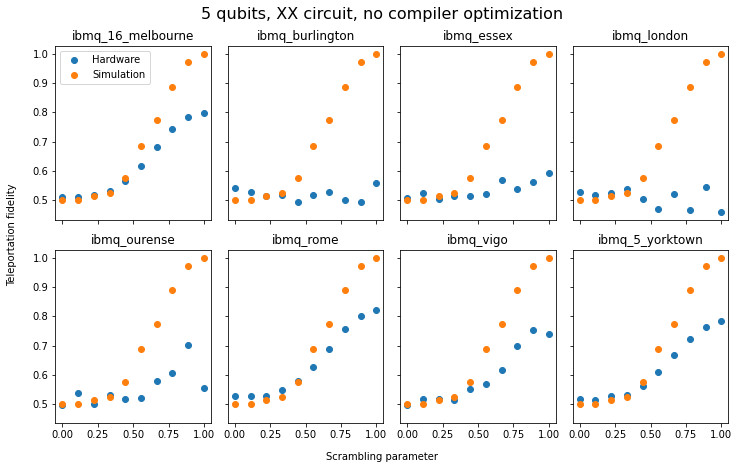

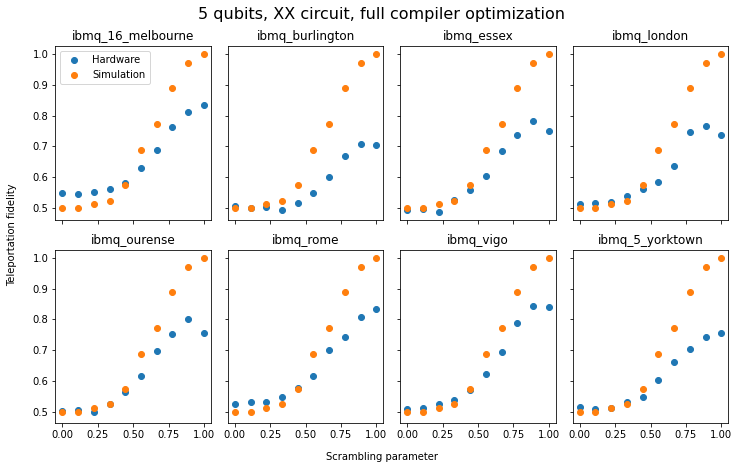

In [46]:
for i in range(2):
    for j in range(2):
        plot_5(i, j, ys_5, 0)

The fidelities obtained using the Grover-search decoder seem to be better than those obtained using post-selection. Without compiler optimization, it looks like `ibmq_16_melbourne`, `ibmq_rome`, `ibmq_vigo`, and `ibmq_5_yorktown` give the best results. Compiler optimization improves the results obtained overall, although this can be more clearly seen with the `ibmq_burlington`, `ibmq_essex`, `ibmq_london`, and `ibmq_ourense` devices. It's not clear why optimization did not work so well when we used post-selection instead of the Grover search.

To see why compiler optimization improves the results, let's take a look at the circuit depths on the `Vigo` device.

In [60]:
from qiskit.compiler import transpile
qbackend = provider.get_backend('ibmq_vigo')
coupling_map = qbackend.configuration().coupling_map

This is the original 5-qubit CZ circuit, depth=23:

In [94]:
print('5-qubit CZ raw circuit, depth=' + str(all_circuits[0][5].depth()))
print(all_circuits[0][5])

5-qubit CZ raw circuit, depth=23
        ┌───┐┌───┐┌───┐  ┌───┐     ┌───────┐   ┌───────┐ ░                     »
  q7_0: ┤ X ├┤ Y ├┤ H ├──┤ S ├───■─┤ RX(0) ├─■─┤ RX(0) ├─░─────────────────────»
        ├───┤└───┘└───┘  └───┘   │ ├───────┤ │ ├───────┤ ░ ┌────────┐┌────────┐»
  q7_1: ┤ H ├──■─────────────────■─┤ RX(0) ├─■─┤ RX(0) ├─░─┤ RZ(pi) ├┤ RX(pi) ├»
        └───┘┌─┴─┐     ┌───────┐   ├───────┤   └───────┘ ░ ├────────┤└────────┘»
  q7_2: ─────┤ X ├──■──┤ RX(0) ├─■─┤ RX(0) ├─────────────░─┤ RX(pi) ├──────────»
        ┌───┐└───┘  │  ├───────┤ │ ├───────┤             ░ ├───────┬┘          »
  q7_3: ┤ H ├──■────■──┤ RX(0) ├─■─┤ RX(0) ├─────────────░─┤ RX(0) ├───────────»
        └───┘┌─┴─┐     └───────┘   └───────┘             ░ └───────┘           »
  q7_4: ─────┤ X ├───────────────────────────────────────░─────────────────────»
             └───┘                                       ░                     »
crb1_0: ════════════════════════════════════════════════════════════════════

Now here's how it looks when we prepare the 5-qubit circuit for the `Vigo` device, i.e. this is what actually runs on the device. Depending on the transpiler seed, it has depth >50, which is already very deep. Printing of the full circuit was commented out since it's very large.

In [95]:
qc2 = transpile(all_circuits[0][5], basis_gates=['u1', 'u2', 'u3', 'cx'], coupling_map=coupling_map, optimization_level=0)
print('5-qubit CZ transpiled circuit, depth=' + str(qc2.depth()))
# print(qc2)

5-qubit CZ transpiled circuit, depth=57


If we optimize the circuit, the circuit depth is significantly reduced, which also reduces the error rates and leads to better results.

In [96]:
qc3 = transpile(all_circuits[0][5], basis_gates=['u1', 'u2', 'u3', 'cx'], coupling_map=coupling_map, optimization_level=3)
print('5-qubit CZ transpiled circuit, depth=' + str(qc3.depth()))
# print(qc3)

5-qubit CZ transpiled circuit, depth=20


Let's also take a look at the circuit depths with the XX circuit.

In [97]:
print('5-qubit XX raw circuit, depth=' + str(all_circuits[1][5].depth()))
print(all_circuits[1][5])

5-qubit XX raw circuit, depth=23
        ┌───┐┌───┐     ┌───┐       ┌───┐   ┌────────────┐┌───────┐»
 q67_0: ┤ X ├┤ Y ├─────┤ H ├───────┤ S ├───┤0           ├┤ RZ(0) ├»
        ├───┤└───┘     └───┘       └───┘   │  RXX(pi/2) │├───────┤»
 q67_1: ┤ H ├──■───────────────────────────┤1           ├┤ RZ(0) ├»
        └───┘┌─┴─┐┌─────────────┐┌───────┐┌┴────────────┤├───────┤»
 q67_2: ─────┤ X ├┤0            ├┤ RZ(0) ├┤0            ├┤ RZ(0) ├»
        ┌───┐└───┘│  RXX(-pi/2) │├───────┤│  RXX(-pi/2) │├───────┤»
 q67_3: ┤ H ├──■──┤1            ├┤ RZ(0) ├┤1            ├┤ RZ(0) ├»
        └───┘┌─┴─┐└─────────────┘└───────┘└─────────────┘└───────┘»
 q67_4: ─────┤ X ├────────────────────────────────────────────────»
             └───┘                                                »
crb1_0: ══════════════════════════════════════════════════════════»
                                                                  »
crb2_0: ══════════════════════════════════════════════════════════»
               

In [98]:
qc2 = transpile(all_circuits[1][5], basis_gates=['u1', 'u2', 'u3', 'cx'], coupling_map=coupling_map, optimization_level=0)
print('5-qubit XX transpiled circuit, depth=' + str(qc2.depth()))
# print(qc2)

5-qubit XX transpiled circuit, depth=69


In [99]:
qc3 = transpile(all_circuits[1][5], basis_gates=['u1', 'u2', 'u3', 'cx'], coupling_map=coupling_map, optimization_level=3)
print('5-qubit XX transpiled circuit, depth=' + str(qc3.depth()))
# print(qc3)

5-qubit XX transpiled circuit, depth=21


With the XX gates, the original circuit depth remains at 23, but the transpiled circuit is significantly deeper than the CZ circuit. However, both transpiled circuits with maximum optimization have similar circuit depths of ~20.

## 7-15 Qubit Protocols

Let's first try running on the XX circuit with full optimization.

In [ ]:
ns = list(range(7, 15, 2))
outs_xx = []
for n in ns:
    outs = run(n, i_choices=[1], j_choices=[1])
    outs_xx.append(outs)

In [ ]:
ys_xx = []
for i in range(len(ns)):
    n = ns[i]
    ys = process(n, outs_xx[i], i_choices=[1], j_choices=[1])
    ys_xx.append(ys)
ys_xx = np.array(ys_xx)

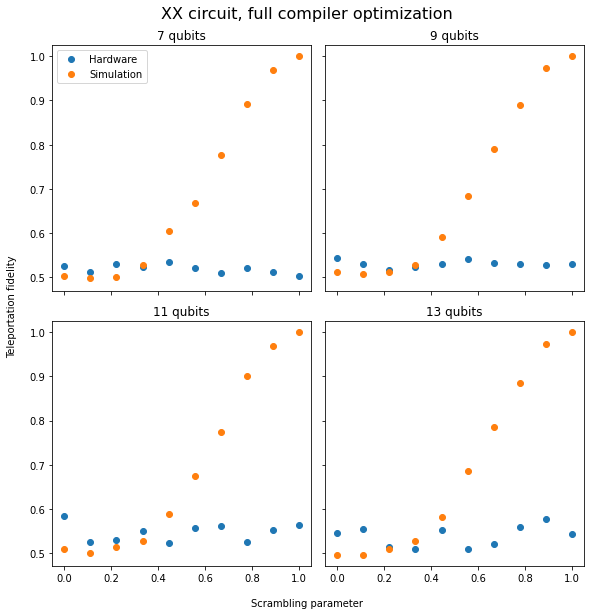

In [37]:
plot_n(1, 1, ns, ys_xx)

As with the case using post-selection, it didn't work. How about the other configurations?

In [ ]:
ns = list(range(7, 15, 2))
outs_xx_no_opt = []
for n in ns:
    outs = run(n, i_choices=[1], j_choices=[0])
    outs_xx_no_opt.append(outs)

In [ ]:
ys_xx_no_opt = []
for i in range(len(ns)):
    n = ns[i]
    ys = process(n, outs_xx_no_opt[i], i_choices=[1], j_choices=[0])
    ys_xx_no_opt.append(ys)
ys_xx_no_opt = np.array(ys_xx_no_opt)

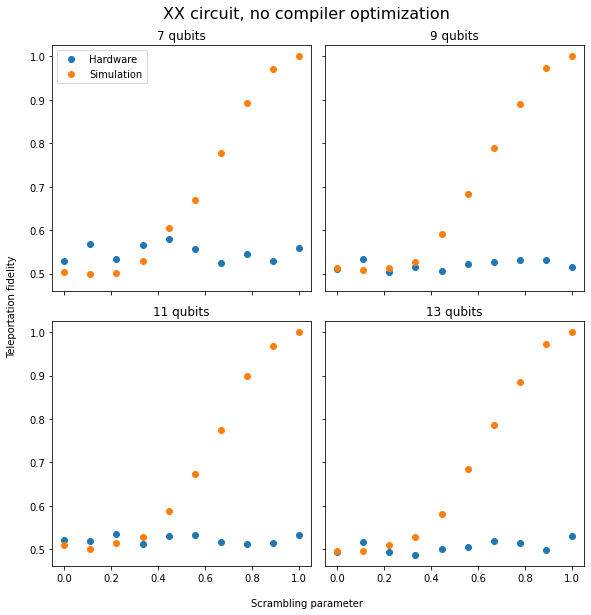

In [38]:
plot_n(1, 0, ns, ys_xx_no_opt)

In [ ]:
ns = list(range(7, 15, 2))
outs_cz_no_opt = []
for n in ns:
    outs = run(n, i_choices=[0], j_choices=[0])
    outs_cz_no_opt.append(outs)

In [ ]:
ys_cz_no_opt = []
for i in range(len(ns)):
    n = ns[i]
    ys = process(n, outs_cz_no_opt[i], i_choices=[0], j_choices=[0])
    ys_cz_no_opt.append(ys)
ys_cz_no_opt = np.array(ys_cz_no_opt)

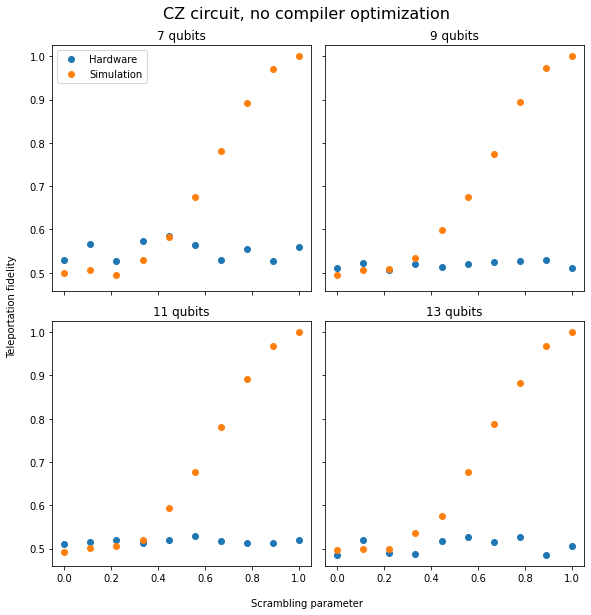

In [39]:
plot_n(0, 0, ns, ys_cz_no_opt)

In [ ]:
ns = list(range(7, 15, 2))
outs_cz = []
for n in ns:
    outs = run(n, i_choices=[0], j_choices=[1])
    outs_cz.append(outs)

In [ ]:
ys_cz = []
for i in range(len(ns)):
    n = ns[i]
    ys = process(n, outs_cz[i], i_choices=[0], j_choices=[1])
    ys_cz.append(ys)
ys_cz = np.array(ys_cz)

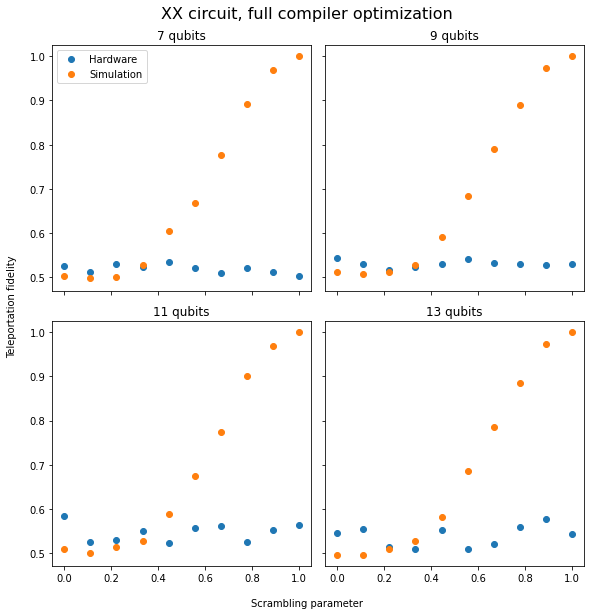

In [37]:
plot_n(0, 1, ns, ys_xx)

No too. Let's take a look at the depth of the 7-qubit CZ circuit.

In [109]:
from qiskit.compiler import transpile
qbackend = provider.get_backend('ibmq_16_melbourne')
coupling_map = qbackend.configuration().coupling_map

In [112]:
print('CZ raw circuit, depth=' + str(all_circuits[2][5].depth()))
print(all_circuits[2][5])

CZ raw circuit, depth=31
         ┌───┐┌───┐┌───┐┌───┐               ┌───────┐               ┌───────┐»
q1292_0: ┤ X ├┤ Y ├┤ H ├┤ S ├─■────────■────┤ RX(0) ├─■────────■────┤ RX(0) ├»
         ├───┤└───┘└───┘└───┘ │        │    ├───────┤ │        │    ├───────┤»
q1292_1: ┤ H ├──■─────────────■──■─────┼────┤ RX(0) ├─■──■─────┼────┤ RX(0) ├»
         ├───┤  │                │     │    ├───────┤    │     │    ├───────┤»
q1292_2: ┤ H ├──┼────■───────────■─────■────┤ RX(0) ├────■─────■────┤ RX(0) ├»
         └───┘  │  ┌─┴─┐           ┌───────┐└───────┘      ┌───────┐└───────┘»
q1292_3: ───────┼──┤ X ├──■──────■─┤ RX(0) ├────■────────■─┤ RX(0) ├─────────»
              ┌─┴─┐└───┘  │      │ ├───────┤    │        │ ├───────┤         »
q1292_4: ─────┤ X ├───────■───■──┼─┤ RX(0) ├────■─────■──┼─┤ RX(0) ├─────────»
         ┌───┐└───┘           │  │ ├───────┤          │  │ ├───────┤         »
q1292_5: ┤ H ├──■─────────────■──■─┤ RX(0) ├──────────■──■─┤ RX(0) ├─────────»
         └───┘┌─┴─┐        

Adding the Grover subcircuit increases the circuit depth by a factor of 2 from 15 (CZ circuit using post-selection) to 31. Most of the contribution is due to the unitary $U^T$. With such a deep circuit to begin with, perhaps it's not surprising that we were not able to obtain any meaningful results due to potentially large errors incurred in NISQ devices.

In [111]:
qc4 = transpile(all_circuits[2][5], basis_gates=['u1', 'u2', 'u3', 'cx'], coupling_map=coupling_map, optimization_level=0)
print('7-qubit CZ transpiled circuit, depth=' + str(qc4.depth()))
# print(qc4)

7-qubit CZ transpiled circuit, depth=89


In [113]:
qc5 = transpile(all_circuits[2][5], basis_gates=['u1', 'u2', 'u3', 'cx'], coupling_map=coupling_map, optimization_level=3)
print('7-qubit CZ transpiled circuit, depth=' + str(qc5.depth()))
# print(qc5)

7-qubit CZ transpiled circuit, depth=73


Not much advantage is offered through maximum optimization either.